# Goal: Estimate Volume of an Object

This is programming project aims to estimate the volume of an object using stereo vision. The procedure is described on page 67 of the document below, as well as this write up. 
Some parts of the code is recycled from previous projects.

https://carlos-hernandez.org/papers/fnt_mvs_2015.pdf

"First, implementing stereo rectification is a great idea and builds off of the work we did in class, so it's a great target. I don't think Blender will generate radial distortion, 
so I don't expect that you'll need to model that effect (though I could be wrong).



Second, the NCC depth map technique we impemented in class, so (while interesting) is not going to count for much in your "implementation" section.



If your images are coming from Blender, you should not need to compute any segmentation: you can make the background transparent and use that to mask you image. 
To compute the volume of the object, you will probably want to look into one of the multi-view stereo applications that I discussed in class and try implementing that, 
since the described procedure is not generally capable of giving you volume (you need to combine the 2D projections somehow, which it does not seem that you are doing).



The LK optical flow algorithm seems like a good alternative plan; so pick whichever you would like. There are also a few open source datasets for optical flow if you'd like 
to use those: https://vision.middlebury.edu/flow/data/"

In [1]:
# Starter code (run this first)
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps


In [2]:
def load_image(filepath):
    """Loads an image into a numpy array.
    Note: image will have 3 color channels [r, g, b]."""
    img = np.float32(Image.open(filepath))
    #img = ImageOps.grayscale(img)
    return cv.normalize(img, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
    #return (np.asarray(img).astype('uint8')/255)[:, :, :3]

### 1.1 Initial Feature Matching
We need to detect blob and corner features
in each image using the Difference-of-Gaussian (DoG) and Harris operators. (p.68)

In [3]:
sift = cv.SIFT_create() # sift detector uses difference of gaussian for feature detection

# get feature matches between two images using SIFT
def get_point_matches(img1, img2):
    """Returns matches as array: (feature track, image, coord)"""

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=10)
    search_params = dict(checks=100)
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    good = []
    pts1 = []
    pts2 = []
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            good.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
        
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_LMEDS)
    # We select only inlier points
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]
    
    return np.stack((pts1, pts2), axis=1)
# combine feature matches
def combine_matches(matches_a, matches_b):
    """Assumes that the 0'th image is the same between them."""
    combined_matches = []
    for ii in range(matches_a.shape[0]):
        ma0 = matches_a[ii, 0]
        # Find the match in b
        mi = np.where((matches_b[:, 0] == ma0).all(axis=1))[0]

        # If a match is found, add to the array
        if mi.size > 0:
            ma = matches_a[ii]
            mb = matches_b[int(mi[0])]
            combined_matches.append(np.concatenate(
                (ma, mb[1:]), axis=0))

    return np.array(combined_matches)



### 1.2 Model Fitting
RANSAC-based methods randomly sample the 
matches to generate candidate models and select the model with 
the maximum number of consenting matches, which also 
defines the number of remaining models to test

In [4]:
## RANSAC Solution
def solve_homography(matches, base_img, img_example, rounds=100, sigma=5, s=4):  
# You will be computing this yourself using your implementation
# of the `solve_homography` function.
#    H_computed = [
#        [ 1.21083264e+00, -8.97707425e-03,  1.11129596e+00],
#        [ 3.15219064e-03,  1.22310850e+00, -1.67420761e+00],
#        [ 1.96243539e-05,  6.50992714e-05,  1.00000000e+00]]

    A = []
    num_rows = np.arange(len(matches))

    
    for i in num_rows:
        A.append([matches[i][0][0], matches[i][0][1], 1, 0, 0, 0, (-1*matches[i][1][0]*matches[i][0][0]), (-1*matches[i][1][0]*matches[i][0][1]), (-1*matches[i][1][1])])
        A.append([0, 0, 0, matches[i][0][0], matches[i][0][1], 1, (-1*matches[i][1][1]*matches[i][0][0]), (-1*matches[i][1][1]*matches[i][0][1]), (-1*matches[i][1][1])])
        
    num_rows = np.arange(len(A))
    A = np.stack(A, axis=0)
    [U, S, Vt] = np.linalg.svd(A)
    homography = Vt[-1].reshape(3, 3)
    
    #visualize_computed_transform(base_img, img_example, homography, matches)
    return homography

def solve_homography_ransac(matches, img_base, img_transformed, rounds=100, sigma=5, s=4):
    num_inliers = 0
    best_inliers = []
    best_H = []
    
    def get_inliers(matches, H, dist=sigma, chsq_thresh=5.99):
        orig_points = np.ones((matches.shape[0], 3))
        orig_points = np.stack(
            (matches[:,0,0].flatten(), matches[:,0,1].flatten(), np.ones(matches.shape[0])),
            axis=-1)
 
        trans_points = np.matmul(H, orig_points.T).T
        trans_points[:, 0] = trans_points[:, 0] / trans_points[:, 2]
        trans_points[:, 1] = trans_points[:, 1] / trans_points[:, 2]
        target_points = np.stack(
            (matches[:,1,0].flatten(), matches[:,1,1].flatten(), np.ones(matches.shape[0])),
            axis=-1)
        rsq = (
            np.abs(trans_points[:, 0] - target_points[:, 0]) ** 2 +
            np.abs(trans_points[:, 1] - target_points[:, 1]) ** 2
        )
        return matches[rsq <= chsq_thresh * (dist**2)]

    for _ in range(rounds):
        ps = np.random.choice(np.arange(matches.shape[0]), size=s)
        ms = matches[ps]
        H = solve_homography(ms, img_base, img_transformed)
        inliers = get_inliers(matches, H, sigma)
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_H = H.copy()

    best_H = solve_homography(best_inliers, img_base, img_transformed)
    best_inliers = get_inliers(matches, best_H, sigma)

    return best_H


In [5]:
def visualize_matches(img_a, img_b, matches, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(20,20))
        ax = plt.gca()
    
    sa = img_a.shape
    sb = img_b.shape
    sp = 40
    off = sa[1]+sp
    
    merged_imgs = np.zeros(
        (max(sa[0], sb[0]), sa[1]+sb[1]+sp),
        dtype=np.float)
    merged_imgs[0:sa[0], 0:sa[1]] = img_a
    merged_imgs[0:sb[0], sa[1]+sp:] = img_b
    ax.imshow(merged_imgs)
    
    for m in matches:
        ax.plot([m[0][0], m[1][0]+off], [m[0][1], m[1][1]], 'r', alpha=0.5)



In [6]:
def transform_image(image, tmat):
    import cv2
    return cv2.warpPerspective(
        image, 
        np.array(tmat).astype(float), 
        dsize=(image.shape[1], image.shape[0]))

def visualize_computed_transform(image_base, image_transformed, H, matches):
    fig = plt.figure(figsize=(8, 8), dpi=150)
    tmat = np.linalg.inv(H)
    image_rec = transform_image(image_transformed, tmat)
    
    # Plotting
    ax = plt.subplot(2, 1, 1)
    visualize_matches(image_base, image_transformed, matches, ax)
    plt.title('Base Images (with matches)')
    ax = plt.subplot(2, 2, 3)
    plt.imshow(image_rec, vmin=0, vmax=1)
    plt.title('Reconstructed Image')
    ax = plt.subplot(2, 2, 4)
    plt.imshow(image_base - image_rec, vmin=-0.3, vmax=0.3, cmap='PiYG')
    plt.title('Reconstruction Difference')

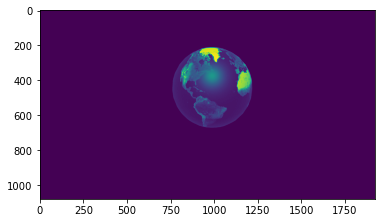

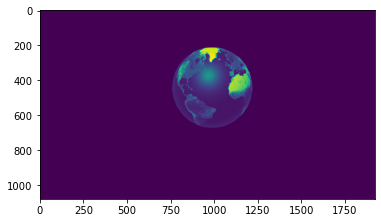

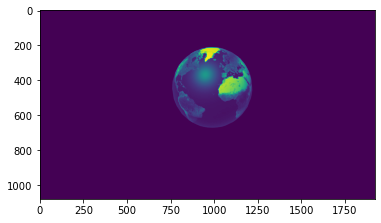

In [7]:
test1 = load_image('./world_rotate/trans_01.png')
fig1 = plt.figure()
plt.imshow(test1[:, :, 0])

fig2 = plt.figure()
test2 = load_image('./world_rotate/trans_02.png')
plt.imshow(test2[:, :, 0])

fig3 = plt.figure()
test3 = load_image('./world_rotate/trans_03.png')
plt.imshow(test3[:, :, 0])

In [8]:
matches1 = get_point_matches(test1, test2)
matches2 = get_point_matches(test2[:, :, 0], test3[:, :, 0])

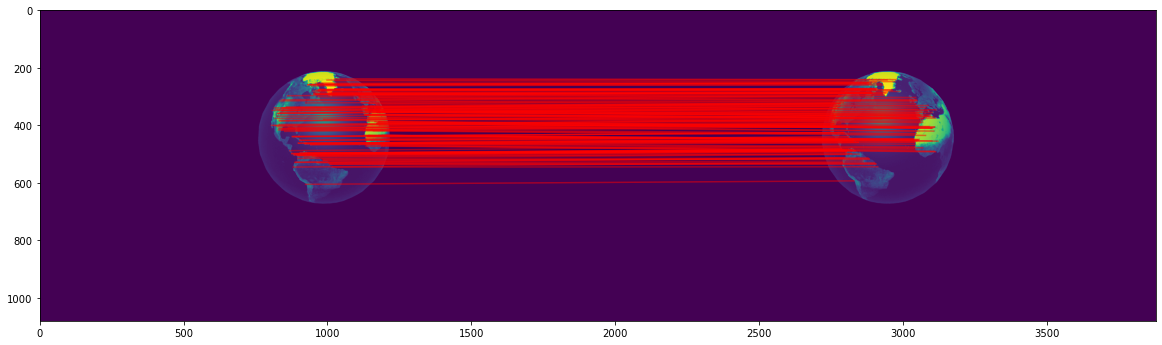

In [9]:
visualize_matches(test1[:, :, 0], test2[:, :, 0], matches1)

In [10]:
#combined_matches = combine_matches(matches1, matches2)

In [11]:
matches1[:,0,0].flatten().shape

(165,)

In [12]:
matches1.shape[0]

165

In [13]:
h_graph = solve_homography_ransac(matches1, test1[:,:,0], test2[:,:,0], rounds=100, sigma=5, s=4)

In [14]:
def visualize_computed_transform(image_base, image_transformed, H, matches):
    fig = plt.figure(figsize=(8, 8), dpi=150)
    tmat = np.linalg.inv(H)
    image_rec = transform_image(image_transformed, tmat)
    
    # Plotting
    ax = plt.subplot(2, 1, 1)
    visualize_matches(image_base, image_transformed, matches, ax)
    plt.title('Base Images (with matches)')
    ax = plt.subplot(2, 2, 3)
    plt.imshow(image_rec, vmin=0, vmax=1)
    plt.title('Reconstructed Image')
    ax = plt.subplot(2, 2, 4)
    plt.imshow(image_base - image_rec, vmin=-0.3, vmax=0.3, cmap='PiYG')
    plt.title('Reconstruction Difference')



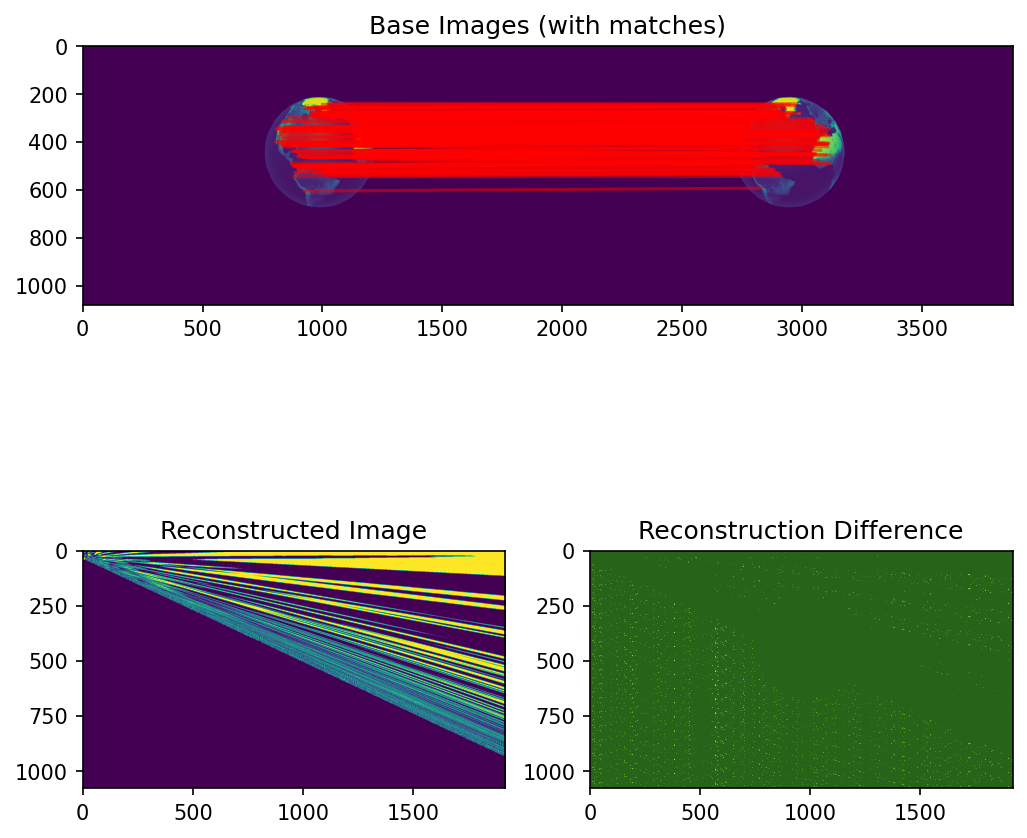

In [16]:
#np_matches = np.array([[fa.x, fa.y, fb.x, fb.y] for fa, fb in matches])
visualize_computed_transform(test1[:,:,0], test2[:,:,0], h_graph, matches1)